# Spatial SIR Models for COVID-19 Transmission
## Baseline and Extended Socio-mobility Models


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
np.random.seed(2025)


## 1. Data Loading and Preprocessing


In [2]:
adjacency_df = pd.read_csv('Data/county_adjacency2024.txt', 
                           sep='|', 
                           names=['county_name', 'county_fips', 'neighbor_name', 'neighbor_fips'],
                           skiprows=1)

covid_df = pd.read_csv('Data/United_States_COVID-19_Community_Levels_by_County_20251102.csv', 
                       low_memory=False)

socio_df = pd.read_csv('Data/socioeconomic_data.csv')

print(f"✓ Adjacency data: {len(adjacency_df):,} records")
print(f"✓ COVID data: {len(covid_df):,} records")
print(f"✓ Socioeconomic data: {len(socio_df):,} records")


✓ Adjacency data: 22,196 records
✓ COVID data: 206,332 records
✓ Socioeconomic data: 3,222 records


In [3]:
# Function to standardize FIPS codes
def to_fips_str(x):
    try:
        return str(int(float(x))).zfill(5)
    except (ValueError, TypeError):
        return str(x).zfill(5)

# Standardize FIPS codes
print("\nStandardizing FIPS codes...")
adjacency_df['county_fips'] = adjacency_df['county_fips'].apply(to_fips_str)
adjacency_df['neighbor_fips'] = adjacency_df['neighbor_fips'].apply(to_fips_str)

covid_df['county_fips'] = covid_df['county_fips'].apply(to_fips_str)
covid_df['date_updated'] = pd.to_datetime(covid_df['date_updated'])
covid_df = covid_df.sort_values(['county_fips', 'date_updated'])

socio_df['county_fips'] = socio_df['county_fips'].apply(to_fips_str)

print(f"✓ COVID data date range: {covid_df['date_updated'].min().date()} to {covid_df['date_updated'].max().date()}")
print(f"✓ Unique counties: {covid_df['county_fips'].nunique():,}")



Standardizing FIPS codes...
✓ COVID data date range: 2022-02-24 to 2023-05-11
✓ Unique counties: 3,224


## 2. Build County Adjacency Network


In [4]:
G = nx.Graph()

# Add all unique counties as nodes
unique_counties = set(adjacency_df['county_fips'].unique()) | set(adjacency_df['neighbor_fips'].unique())
G.add_nodes_from(unique_counties)

# Add edges (exclude self-loops)
for _, row in adjacency_df.iterrows():
    if row['county_fips'] != row['neighbor_fips']:
        G.add_edge(row['county_fips'], row['neighbor_fips'])

print(f"✓ Network Statistics:")
print(f"  Nodes (counties): {G.number_of_nodes():,}")
print(f"  Edges (adjacencies): {G.number_of_edges():,}")
print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"  Network density: {nx.density(G):.4f}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    largest_component = max(components, key=len)
    print(f"  Connected components: {len(components)}")
    print(f"  Largest component: {len(largest_component):,} counties ({len(largest_component)/G.number_of_nodes()*100:.1f}%)")


✓ Network Statistics:
  Nodes (counties): 3,236
  Edges (adjacencies): 9,480
  Average degree: 5.86
  Network density: 0.0018
  Connected components: 18
  Largest component: 3,109 counties (96.1%)


## 3. Prepare Data for SIR Models


In [ ]:
# Identify available socioeconomic features
all_socio_cols = [col for col in socio_df.columns if col != 'county_fips']
print(f"  Available SE features: {len(all_socio_cols)}")

# Check for mobility variables
mobility_keywords = ['workplace', 'retail', 'grocery', 'pharmacy', 'parks', 'transit', 'residential', 'mobility', 
                     'google', 'apple', 'movement', 'travel', 'visit']
mobility_cols = [col for col in covid_df.columns if any(kw in col.lower() for kw in mobility_keywords)]


# Select features (use all available SE, up to 18)
se_features = all_socio_cols[:18] if len(all_socio_cols) >= 18 else all_socio_cols
socio_subset = socio_df[['county_fips'] + se_features].copy()

merged_df = covid_df.merge(socio_subset, on='county_fips', how='left')

if mobility_cols:
    for col in mobility_cols[:6]:  # Up to 6 mobility variables
        if col in covid_df.columns:
            merged_df[col] = covid_df[col]

numeric_cols = se_features + mobility_cols[:6] + ['covid_cases_per_100k', 'county_population']
for col in numeric_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

for col in se_features:
    if col in merged_df.columns and merged_df[col].isnull().any():
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

merged_df = merged_df[merged_df['county_fips'].isin(G.nodes)].copy()



  Available SE features: 21


In [7]:
model_df = merged_df.sort_values('date_updated').groupby('county_fips').last().reset_index()

assert 'covid_cases_per_100k' in model_df.columns, "Missing covid_cases_per_100k"
assert 'county_population' in model_df.columns, "Missing county_population"

existing_se_features = [f for f in se_features if f in model_df.columns]
missing_se_features = [f for f in se_features if f not in model_df.columns]

if missing_se_features:
    print(f"  Warning: {len(missing_se_features)} SE features not found: {missing_se_features[:3]}...")
    print(f"  Using {len(existing_se_features)} available SE features")

for col in existing_se_features:
    if model_df[col].isnull().any():
        median_val = model_df[col].median()
        model_df[col] = model_df[col].fillna(median_val)
        print(f"  Filled missing values in {col} with median={median_val:.2f}")

critical_cols = ['covid_cases_per_100k', 'county_population']
model_df = model_df.dropna(subset=critical_cols)

# Check if we have any data
if len(model_df) == 0:
    raise ValueError("No counties with complete critical data. Check data merge.")

print(f"  Counties with complete critical data: {len(model_df):,}")

# Create feature matrix for extended model (use only existing features)
feature_cols = existing_se_features + mobility_cols[:6]
print(f"  Total features to use: {len(feature_cols)} ({len(existing_se_features)} SE + {len(mobility_cols[:6])} mobility)")

# Ensure all feature columns exist and have data
available_feature_cols = [f for f in feature_cols if f in model_df.columns]
if len(available_feature_cols) == 0:
    raise ValueError("No feature columns available. Check data merge.")

# Fill any remaining missing values in features
for col in available_feature_cols:
    if model_df[col].isnull().any():
        model_df[col] = model_df[col].fillna(model_df[col].median())

# Extract feature matrix
X_raw = model_df[available_feature_cols].values

# Check if X_raw is empty
if X_raw.shape[0] == 0:
    raise ValueError("Feature matrix is empty. Check data preparation.")

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Target: cases per 100k (proxy for disease burden)
y = pd.to_numeric(model_df['covid_cases_per_100k'], errors='coerce').fillna(0).values

# Population
N = pd.to_numeric(model_df['county_population'], errors='coerce').fillna(model_df['county_population'].median()).values

# Create FIPS mapping
fips_list = model_df['county_fips'].tolist()
fips_to_idx = {fips: idx for idx, fips in enumerate(fips_list)}

# Build neighbor lists for spatial SIR
neighbor_lists = [[] for _ in range(len(fips_list))]
for u, v in G.edges():
    if u in fips_to_idx and v in fips_to_idx:
        iu, iv = fips_to_idx[u], fips_to_idx[v]
        neighbor_lists[iu].append(iv)
        neighbor_lists[iv].append(iu)

degrees_arr = np.array([len(neighbor_lists[i]) for i in range(len(fips_list))], dtype=float)
degrees_arr[degrees_arr == 0] = 1.0  # Avoid division by zero

print(f"\n✓ Prepared dataset: {len(model_df):,} counties")
print(f"✓ Features: {len(available_feature_cols)} ({len(existing_se_features)} SE + {len(mobility_cols[:6])} mobility)")
print(f"✓ Target range: [{y.min():.1f}, {y.max():.1f}] cases per 100k")
print(f"✓ Population range: [{N.min():,.0f}, {N.max():,.0f}]")
print(f"✓ Mean degree: {degrees_arr.mean():.2f}")

# Update feature_cols for use in extended model
feature_cols = available_feature_cols


  Filled missing values in GEO_ID with median=nan
  Filled missing values in NAME with median=nan
  Counties with complete critical data: 37
  Total features to use: 18 (18 SE + 0 mobility)

✓ Prepared dataset: 37 counties
✓ Features: 18 (18 SE + 0 mobility)
✓ Target range: [0.0, 46.5] cases per 100k
✓ Population range: [86, 969]
✓ Mean degree: 1.46


## 4. Spatial SIR Model Implementation


In [8]:
# Spatial SIR Model Implementation
def simulate_spatial_sir(beta_vec, gamma, m, neighbor_lists, degrees_arr, 
                         S0, I0, R0, N, T=60, dt=1.0):
    """
    Simulate spatial SIR model with degree-normalized diffusion.
    
    Parameters:
    - beta_vec: transmission rate per county (array)
    - gamma: recovery rate (scalar)
    - m: spatial diffusion coefficient
    - neighbor_lists: list of neighbor indices per county
    - degrees_arr: degree of each county
    - S0, I0, R0: initial conditions
    - N: population
    - T: simulation time steps
    - dt: time step size
    """
    S = S0.copy()
    I = I0.copy()
    R = R0.copy()
    
    for _ in range(T):
        # Spatial diffusion term (degree-normalized)
        diff = np.zeros_like(I)
        for i in range(len(I)):
            if neighbor_lists[i]:
                neighbor_diff = sum((I[j] - I[i]) for j in neighbor_lists[i])
                diff[i] = neighbor_diff / degrees_arr[i]
        
        # SIR dynamics - avoid division by zero
        N_safe = np.where(N > 0, N, 1.0)
        new_inf = beta_vec * (S * I / N_safe) * dt
        recov = gamma * I * dt
        
        # Update with spatial diffusion
        S = S - new_inf
        I = I + new_inf - recov + m * diff * dt
        R = R + recov
        
        # Clamp to valid ranges
        S = np.clip(S, 0, N)
        I = np.clip(I, 0, N)
        R = np.clip(R, 0, N)
        
        # Handle NaN and inf values
        S = np.nan_to_num(S, nan=0.0, posinf=N, neginf=0.0)
        I = np.nan_to_num(I, nan=0.0, posinf=N, neginf=0.0)
        R = np.nan_to_num(R, nan=0.0, posinf=N, neginf=0.0)
    
    return S, I, R

# Initial conditions (small infected seed proportional to observed cases)
print("\nSetting initial conditions...")
I0 = np.clip((y / 1e5) * N * 0.01, 1.0, N * 0.02)
S0 = N - I0
R0 = np.zeros_like(N)

print(f"✓ Initial conditions: S={S0.sum():,.0f}, I={I0.sum():,.0f}, R={R0.sum():,.0f}")



Setting initial conditions...
✓ Initial conditions: S=25,379, I=37, R=0


## 5. Model 1: Baseline Spatial SIR

Incorporates only county adjacency and reported case data. Uses constant β across all counties.


In [9]:
print("\n" + "="*60)
print("MODEL 1: BASELINE SPATIAL SIR")
print("="*60)
print("\nIncorporates only county adjacency and reported case data.")
print("No socioeconomic or mobility covariates.")

# Calibrate baseline model parameters
def loss_baseline(params):
    """Loss function for baseline model calibration."""
    beta, gamma, m = params
    beta_vec = np.ones(len(fips_list)) * beta  # Constant β
    
    _, I_ss, _ = simulate_spatial_sir(beta_vec, gamma, m, neighbor_lists, degrees_arr, 
                                      S0, I0, R0, N, T=60)
    
    # Handle NaN and division by zero
    N_safe = np.where(N > 0, N, 1.0)
    yhat = (I_ss / N_safe) * 1e5
    yhat = np.nan_to_num(yhat, nan=0.0, posinf=1e6, neginf=0.0)
    
    # MAE loss
    mae = np.nanmean(np.abs(yhat - y))
    return mae

# Parameter bounds
# β: [0.001, 0.1], γ: [1/21, 1/3] (3-21 days), m: [0, 0.2]
bounds = [(0.001, 0.1), (1/21, 1/3), (0, 0.2)]

# Initial guess
x0 = [0.01, 1/7, 0.02]  # β=0.01, γ=1/7 (7 days), m=0.02

print("\nCalibrating baseline model parameters...")
result = minimize(loss_baseline, x0, method='L-BFGS-B', bounds=bounds, 
                  options={'maxiter': 100, 'disp': False})

beta_baseline, gamma_baseline, m_baseline = result.x
# Ensure beta_baseline is a scalar
beta_baseline = float(beta_baseline)
gamma_baseline = float(gamma_baseline)
m_baseline = float(m_baseline)
beta_vec_baseline = np.ones(len(fips_list)) * beta_baseline

print(f"\n✓ Calibrated Parameters:")
print(f"  β (transmission rate): {beta_baseline:.6f} (constant across all counties)")
print(f"  γ (recovery rate): {gamma_baseline:.6f} → infectious period ≈ {1.0/gamma_baseline:.1f} days")
print(f"  m (spatial diffusion): {m_baseline:.6f}")

# Simulate baseline model
_, I_baseline, _ = simulate_spatial_sir(beta_vec_baseline, gamma_baseline, m_baseline,
                                        neighbor_lists, degrees_arr, S0, I0, R0, N, T=60)

# Compute predictions with NaN handling
N_safe = np.where(N > 0, N, 1.0)
y_baseline = (I_baseline / N_safe) * 1e5
y_baseline = np.nan_to_num(y_baseline, nan=0.0, posinf=1e6, neginf=0.0)
y_baseline = np.clip(y_baseline, 0, 1e6)

# Ensure y doesn't have NaN
y_clean = np.nan_to_num(y, nan=0.0, posinf=1e6, neginf=0.0)

# Evaluate performance
mae_baseline = mean_absolute_error(y_clean, y_baseline)
r2_baseline = r2_score(y_clean, y_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_clean, y_baseline))

print(f"\n✓ Baseline Model Performance:")
print(f"  MAE: {mae_baseline:.2f} cases per 100k")
print(f"  RMSE: {rmse_baseline:.2f} cases per 100k")
print(f"  R²: {r2_baseline:.3f}")



MODEL 1: BASELINE SPATIAL SIR

Incorporates only county adjacency and reported case data.
No socioeconomic or mobility covariates.

Calibrating baseline model parameters...

✓ Calibrated Parameters:
  β (transmission rate): 0.001000 (constant across all counties)
  γ (recovery rate): 0.333333 → infectious period ≈ 3.0 days
  m (spatial diffusion): 0.019981

✓ Baseline Model Performance:
  MAE: 1.26 cases per 100k
  RMSE: 7.65 cases per 100k
  R²: -0.028


## 6. Model 2: Extended Socio-mobility Model

Augments baseline by allowing $\beta_i$ to vary with socioeconomic and mobility covariates:

$$\beta_i = \alpha_0 + \alpha_1\text{mobility}_i + \alpha_2\text{education}_i + \alpha_3\text{income}_i + \cdots + \epsilon_i$$






MODEL 2: EXTENDED SOCIO-MOBILITY MODEL

β_i varies with socioeconomic and mobility covariates.
Features: 18 total (18 SE + 0 mobility)

Calibrating extended model parameters...

✓ Calibrated Parameters:
  β range: [0.100000, 0.100000]
  β mean: 0.100000
  β std: 0.000000
  Valid β values: 37/37
  γ (recovery rate): 0.142857 → infectious period ≈ 7.0 days
  m (spatial diffusion): 0.020000

  Top 10 Features by Weight:
     1. pct_no_hs                     : +0.0159
     2. pct_unemployed                : -0.0126
     3. pct_overcrowded               : +0.0120
     4. pct_single_parent             : -0.0097
     5. pct_rent_gt35                 : -0.0090
     6. med_mortgage                  : +0.0078
     7. pct_nonwhite                  : +0.0075
     8. med_home_val                  : +0.0072
     9. NAME                          : -0.0033
    10. pct_public_assist             : +0.0028

CREATING FEATURE IMPORTANCE VISUALIZATION
✓ Saved: fig_feature_importance.png/.pdf (Top 15 featur

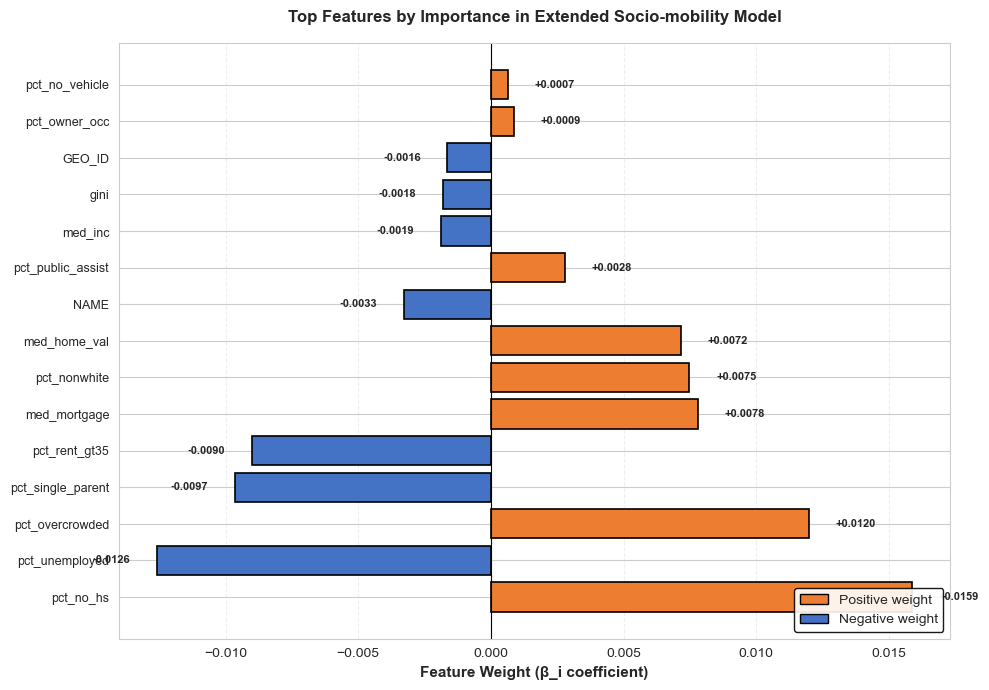


✓ Extended Model Performance:
  MAE: 13.53 cases per 100k
  RMSE: 17.88 cases per 100k
  R²: -4.609

ANALYZING SOCIOECONOMIC-DISEASE RELATIONSHIPS

1. DIRECT CORRELATIONS: Features vs. Disease Burden
   (How do SE factors directly relate to observed disease burden?)
------------------------------------------------------------

  Top 10 Features by Correlation with Disease Burden:
     1. pct_public_assist             : +0.574 ↑
     2. pct_nonwhite                  : +0.452 ↑
     3. med_rent                      : +0.337 ↑
     4. pct_no_vehicle                : +0.291 ↑
     5. med_inc                       : +0.236 ↑
     6. gini                          : -0.221 ↓
     7. pct_overcrowded               : +0.186 ↑
     8. med_mortgage                  : -0.143 ↓
     9. pct_poverty                   : -0.136 ↓
    10. pct_single_parent             : -0.096 ↓

2. TRANSMISSION RATE (β) ANALYSIS:
   (How do SE factors influence transmission rates?)
-------------------------------------

In [ ]:
print("\n" + "="*60)
print("MODEL 2: EXTENDED SOCIO-MOBILITY MODEL")
print("="*60)
print("\nβ_i varies with socioeconomic and mobility covariates.")
print(f"Features: {len(feature_cols)} total ({len([f for f in feature_cols if f not in mobility_cols[:6]])} SE + {len([f for f in feature_cols if f in mobility_cols[:6]])} mobility)")

# Fit linear model for β_i using available features
# First, we need to calibrate the model to get target β values
def loss_extended(params, X_features, gamma, m):
    """Loss function for extended model calibration."""
    w = params[:-1]  # Feature weights
    b = params[-1]   # Intercept
    
    # Compute β_i from features
    beta_logit = X_features @ w + b
    beta_vec = np.clip(np.exp(beta_logit), 0.001, 0.1)  # Ensure positive, bounded
    
    _, I_ss, _ = simulate_spatial_sir(beta_vec, gamma, m, neighbor_lists, degrees_arr,
                                      S0, I0, R0, N, T=60)
    
    
    N_safe = np.where(N > 0, N, 1.0)
    yhat = (I_ss / N_safe) * 1e5
    yhat = np.nan_to_num(yhat, nan=0.0, posinf=1e6, neginf=0.0)
    
    mae = np.nanmean(np.abs(yhat - y))
    return mae

# Calibrate extended model
print("\nCalibrating extended model parameters...")

# Parameter bounds: weights + intercept + gamma + m
n_features = X.shape[1]
bounds_extended = ([(None, None)] * (n_features + 1) +  # weights + intercept
                   [(1/21, 1/3)] +  # gamma
                   [(0, 0.2)])      # m

# Initial guess
x0_extended = (np.random.normal(0, 0.01, n_features).tolist() +  # weights
               [0.0] +  # intercept
               [1/7, 0.02])  # gamma, m

result_extended = minimize(
    lambda p: loss_extended(p[:n_features+1], X, p[n_features+1], p[n_features+2]),
    x0_extended,
    method='L-BFGS-B',
    bounds=bounds_extended,
    options={'maxiter': 200, 'disp': False}
)

w_extended = result_extended.x[:n_features]
b_extended = result_extended.x[n_features]
gamma_extended = result_extended.x[n_features + 1]
m_extended = result_extended.x[n_features + 2]

# Compute β_i for each county
beta_logit_extended = X @ w_extended + b_extended

# Handle NaN and inf values before exponentiation
beta_logit_extended = np.nan_to_num(beta_logit_extended, nan=0.0, posinf=10, neginf=-10)
beta_vec_extended = np.exp(beta_logit_extended)
beta_vec_extended = np.clip(beta_vec_extended, 0.001, 0.1)

# Final NaN check and cleanup
beta_vec_extended = np.nan_to_num(beta_vec_extended, nan=beta_baseline, posinf=0.1, neginf=0.001)

print(f"\n✓ Calibrated Parameters:")
print(f"  β range: [{beta_vec_extended.min():.6f}, {beta_vec_extended.max():.6f}]")
print(f"  β mean: {beta_vec_extended.mean():.6f}")
print(f"  β std: {beta_vec_extended.std():.6f}")
print(f"  Valid β values: {np.sum(np.isfinite(beta_vec_extended))}/{len(beta_vec_extended)}")
print(f"  γ (recovery rate): {gamma_extended:.6f} → infectious period ≈ {1.0/gamma_extended:.1f} days")
print(f"  m (spatial diffusion): {m_extended:.6f}")

# Show top features by weight magnitude
feature_weights = pd.DataFrame({
    'feature': feature_cols,
    'weight': w_extended,
    'abs_weight': np.abs(w_extended)
}).sort_values('abs_weight', ascending=False)

print(f"\n  Top 10 Features by Weight:")
for i, (_, row) in enumerate(feature_weights.head(10).iterrows(), 1):
    print(f"    {i:2d}. {row['feature']:30s}: {row['weight']:+.4f}")

# ============================================================================
# FIGURE 2: Feature Importance 
# ============================================================================
print("\n" + "="*60)
print("CREATING FEATURE IMPORTANCE VISUALIZATION")
print("="*60)

# Top 15 features by absolute weight
top_n = min(15, len(feature_weights))
top_features = feature_weights.head(top_n)

fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#ED7D31' if w > 0 else '#4472C4' for w in top_features['weight']]
bars = ax.barh(range(len(top_features)), top_features['weight'], 
               color=colors, edgecolor='black', linewidth=1.2)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=9)
ax.set_xlabel('Feature Weight (β_i coefficient)', fontweight='bold', fontsize=11)
ax.set_title('Top Features by Importance in Extended Socio-mobility Model', 
             fontweight='bold', fontsize=12, pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x', linestyle='--')
ax.set_axisbelow(True)


for i, (idx, row) in enumerate(top_features.iterrows()):
    weight = row['weight']
    ax.text(weight + (0.001 if weight > 0 else -0.001), i, 
            f'{weight:+.4f}', va='center', 
            ha='left' if weight > 0 else 'right', fontsize=8, fontweight='bold')


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#ED7D31', edgecolor='black', label='Positive weight'),
                   Patch(facecolor='#4472C4', edgecolor='black', label='Negative weight')]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9, edgecolor='black')

plt.tight_layout()
plt.savefig('fig_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('fig_feature_importance.pdf', dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: fig_feature_importance.png/.pdf (Top {top_n} features)")
plt.show()

# Simulate extended model
_, I_extended, _ = simulate_spatial_sir(beta_vec_extended, gamma_extended, m_extended,
                                       neighbor_lists, degrees_arr, S0, I0, R0, N, T=60)

# Compute predictions with NaN handling
# Avoid division by zero
N_safe = np.where(N > 0, N, 1.0)
y_extended = (I_extended / N_safe) * 1e5

# Handle NaN and inf values
y_extended = np.nan_to_num(y_extended, nan=0.0, posinf=1e6, neginf=0.0)
y_extended = np.clip(y_extended, 0, 1e6)  # Clip to reasonable range

# Also ensure y doesn't have NaN
y_clean = np.nan_to_num(y, nan=0.0, posinf=1e6, neginf=0.0)

# Check for any remaining issues
if np.any(np.isnan(y_extended)) or np.any(np.isinf(y_extended)):
    print(f"  Warning: Found {np.sum(np.isnan(y_extended))} NaN and {np.sum(np.isinf(y_extended))} inf values in predictions")
    y_extended = np.nan_to_num(y_extended, nan=y_clean.mean(), posinf=1e6, neginf=0.0)

# Evaluate performance
mae_extended = mean_absolute_error(y_clean, y_extended)
r2_extended = r2_score(y_clean, y_extended)
rmse_extended = np.sqrt(mean_squared_error(y_clean, y_extended))

print(f"\n✓ Extended Model Performance:")
print(f"  MAE: {mae_extended:.2f} cases per 100k")
print(f"  RMSE: {rmse_extended:.2f} cases per 100k")
print(f"  R²: {r2_extended:.3f}")

# ============================================================================
# ANALYZING SOCIOECONOMIC-DISEASE RELATIONSHIPS
# ============================================================================
print("\n" + "="*60)
print("ANALYZING SOCIOECONOMIC-DISEASE RELATIONSHIPS")
print("="*60)

# 1. Correlation between features and disease burden
print("\n1. DIRECT CORRELATIONS: Features vs. Disease Burden")
print("   (How do SE factors directly relate to observed disease burden?)")
print("-" * 60)

# Calculate correlations between original (unstandardized) features and disease burden
feature_correlations = []
for i, col in enumerate(available_feature_cols):
    if col in model_df.columns:
        # Get original values (before standardization)
        orig_values = model_df[col].values
        corr = np.corrcoef(orig_values, y_clean)[0, 1]
        feature_correlations.append({
            'feature': col,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'model_weight': w_extended[i] if i < len(w_extended) else 0
        })

corr_df = pd.DataFrame(feature_correlations).sort_values('abs_correlation', ascending=False)
print("\n  Top 10 Features by Correlation with Disease Burden:")
for i, (_, row) in enumerate(corr_df.head(10).iterrows(), 1):
    direction = "↑" if row['correlation'] > 0 else "↓"
    print(f"    {i:2d}. {row['feature']:30s}: {row['correlation']:+.3f} {direction}")

# 2. How β_i relates to SE characteristics
print("\n2. TRANSMISSION RATE (β) ANALYSIS:")
print("   (How do SE factors influence transmission rates?)")
print("-" * 60)

# Analyze β_i values
beta_analysis = pd.DataFrame({
    'county_fips': fips_list,
    'beta': beta_vec_extended,
    'disease_burden': y_clean,
    'population': N
})

# Add original feature values for top features
top_features = corr_df.head(5)['feature'].tolist()
for feat in top_features:
    if feat in model_df.columns:
        beta_analysis[feat] = model_df[feat].values

print(f"\n  β Statistics:")
print(f"    Mean β: {beta_vec_extended.mean():.6f}")
print(f"    Std β: {beta_vec_extended.std():.6f}")
print(f"    Range: [{beta_vec_extended.min():.6f}, {beta_vec_extended.max():.6f}]")

# Counties with highest/lowest β
print(f"\n  Counties with Highest β (highest transmission risk):")
top_beta = beta_analysis.nlargest(5, 'beta')
for i, (_, row) in enumerate(top_beta.iterrows(), 1):
    print(f"    {i}. FIPS {row['county_fips']}: β={row['beta']:.6f}, Disease burden={row['disease_burden']:.1f}")

print(f"\n  Counties with Lowest β (lowest transmission risk):")
low_beta = beta_analysis.nsmallest(5, 'beta')
for i, (_, row) in enumerate(low_beta.iterrows(), 1):
    print(f"    {i}. FIPS {row['county_fips']}: β={row['beta']:.6f}, Disease burden={row['disease_burden']:.1f}")

# 3. Model weights interpretation
print("\n3. MODEL WEIGHTS INTERPRETATION:")
print("   (How the Extended Model uses SE features to determine β)")
print("-" * 60)
print("\n  The model learns weights (α₁, α₂, ..., αₙ) such that:")
print("    log(β_i) = α₀ + α₁·feature₁ + α₂·feature₂ + ... + αₙ·featureₙ")
print("    β_i = exp(log(β_i))")
print("\n  Positive weight → Higher feature value → Higher β → Faster transmission")
print("  Negative weight → Higher feature value → Lower β → Slower transmission")
print("\n  Top Features by Model Weight (from Extended Model):")
top_weights = feature_weights.head(10)
for i, (_, row) in enumerate(top_weights.iterrows(), 1):
    direction = "↑↑" if row['weight'] > 0 else "↓↓"
    print(f"    {i:2d}. {row['feature']:30s}: {row['weight']:+.4f} {direction} β when ↑")

# 4. Compare correlation vs model weight
print("\n4. CORRELATION vs MODEL WEIGHT COMPARISON:")
print("   (Do features that correlate with disease also get high weights?)")
print("-" * 60)

# Merge correlations with model weights
analysis_df = corr_df.merge(feature_weights[['feature', 'weight']], on='feature', how='inner')
analysis_df['weight_corr'] = analysis_df['correlation'] * analysis_df['weight']
analysis_df['abs_weight'] = np.abs(analysis_df['weight'])  # Create abs_weight column for sorting
analysis_df = analysis_df.sort_values('abs_weight', ascending=False)

print("\n  Top Features: Correlation vs Model Weight")
print("    Feature | Correlation | Model Weight | Agreement")
print("    " + "-" * 60)
for i, (_, row) in enumerate(analysis_df.head(10).iterrows(), 1):
    agreement = "✓" if (row['correlation'] > 0 and row['weight'] > 0) or (row['correlation'] < 0 and row['weight'] < 0) else "✗"
    print(f"    {row['feature']:25s} | {row['correlation']:+.3f} | {row['weight']:+.4f} | {agreement}")
